In [1]:
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saiprasadb2","key":"bb3547730482026e83d19af87d5b372a"}'}

In [3]:
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!ls ~/.kaggle


kaggle.json


In [6]:
!kaggle competitions download -c dogs-vs-cats


 99% 804M/812M [00:04<00:00, 190MB/s]
100% 812M/812M [00:04<00:00, 201MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip



In [8]:
!unzip -qq train.zip


In [9]:
!ls train


cat.0.jpg      cat.1966.jpg  cat.5180.jpg  cat.8396.jpg   dog.1160.jpg	 dog.3575.jpg  dog.6790.jpg
cat.10000.jpg  cat.1967.jpg  cat.5181.jpg  cat.8397.jpg   dog.11610.jpg  dog.3576.jpg  dog.6791.jpg
cat.10001.jpg  cat.1968.jpg  cat.5182.jpg  cat.8398.jpg   dog.11611.jpg  dog.3577.jpg  dog.6792.jpg
cat.10002.jpg  cat.1969.jpg  cat.5183.jpg  cat.8399.jpg   dog.11612.jpg  dog.3578.jpg  dog.6793.jpg
cat.10003.jpg  cat.196.jpg   cat.5184.jpg  cat.839.jpg	  dog.11613.jpg  dog.3579.jpg  dog.6794.jpg
cat.10004.jpg  cat.1970.jpg  cat.5185.jpg  cat.83.jpg	  dog.11614.jpg  dog.357.jpg   dog.6795.jpg
cat.10005.jpg  cat.1971.jpg  cat.5186.jpg  cat.8400.jpg   dog.11615.jpg  dog.3580.jpg  dog.6796.jpg
cat.10006.jpg  cat.1972.jpg  cat.5187.jpg  cat.8401.jpg   dog.11616.jpg  dog.3581.jpg  dog.6797.jpg
cat.10007.jpg  cat.1973.jpg  cat.5188.jpg  cat.8402.jpg   dog.11617.jpg  dog.3582.jpg  dog.6798.jpg
cat.10008.jpg  cat.1974.jpg  cat.5189.jpg  cat.8403.jpg   dog.11618.jpg  dog.3583.jpg  dog.6799.jpg
cat.

Question 1:

copying images to the test, validation, and training directories

In [10]:
import os, shutil, pathlib

original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)


make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)

Loading and processing images with 'image_dataset_from_directory

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train = image_dataset_from_directory(
    base_dataset_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation = image_dataset_from_directory(
    base_dataset_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test = image_dataset_from_directory(
    base_dataset_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Construct a dataset with 1000 instances, each having 16 random values.

In [12]:
import numpy as np
import tensorflow as tf
random_num = np.random.normal(size=(1000, 16))
data = tf.data.Dataset.from_tensor_slices(random_num)

In [13]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
reshapedata = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshapedata):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Building a small neural network to differentiate dog and cat images

In [16]:
for data_batch, labels_batch in train:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape=(180, 180, 3))
l = layers.Rescaling(1./255)(input)
l = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.MaxPooling2D(pool_size=2)(l)
l = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(l)
l = layers.Flatten()(l)
l = layers.Dropout(0.5)(l)
output1 = layers.Dense(1, activation="sigmoid")(l)
model1 = keras.Model(inputs=input, outputs=output1)

preparing model for training

In [18]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

The model is initially developed, followed by training on the training set. To evaluate the model's performance at each stage, we utilize the validation set.

In [19]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

The dataset is used to refine the model's parameters.


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback1 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history1 = model1.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callback1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.5031 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5136 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.4992 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6870
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5295 - loss: 0.6878 - val_accuracy: 0.5900 - val_loss: 0.6750
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6143 - loss: 0.6604 - val_accuracy: 0.6360 - val_loss: 0.7417
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6240 - loss: 0.6626 - val_accuracy: 0.6380 - val_loss: 0.6314
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6721 - loss: 0.6090 - val_accuracy: 0.6720 - val_loss: 0.6209
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6850 - loss: 0.5729 - val_accuracy: 0.6670 

To visualize the model's performance over time, training curves for accuracy and loss were created.


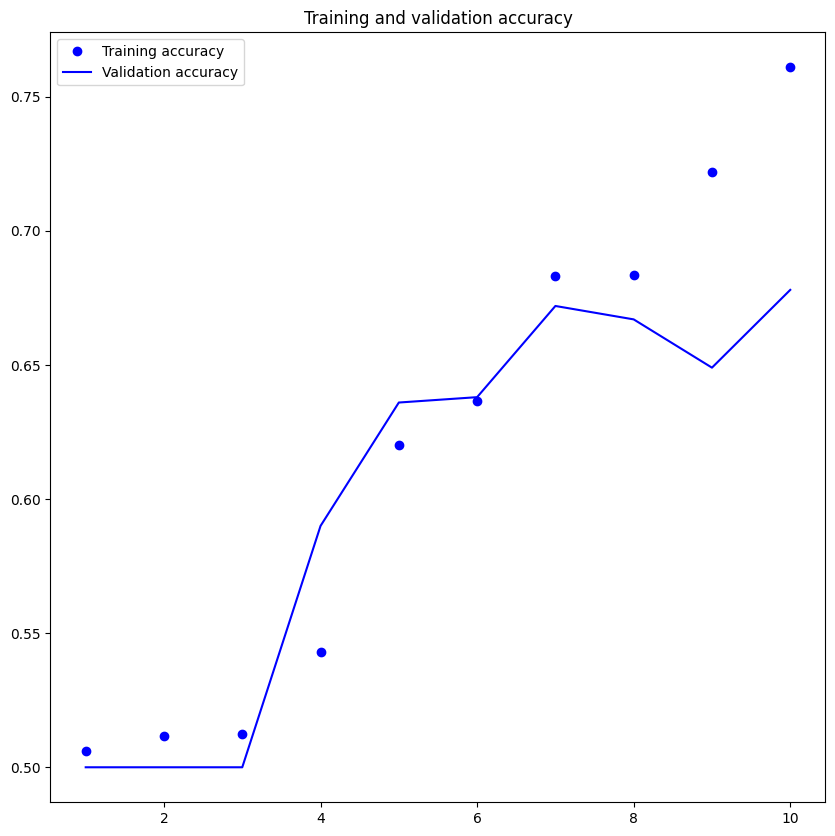

<Figure size 640x480 with 0 Axes>

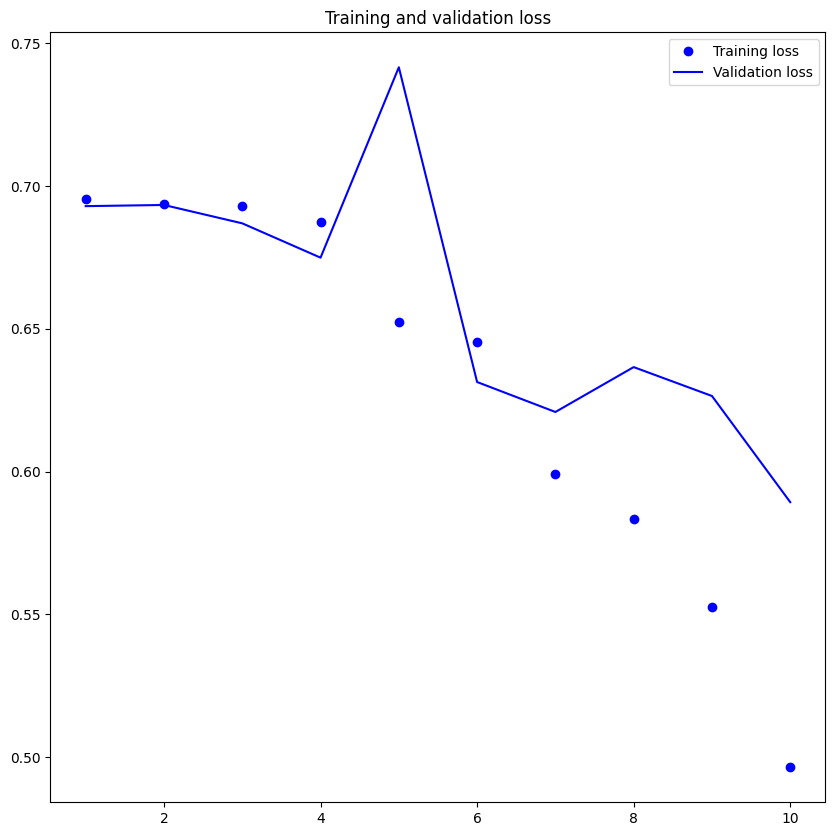

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy1 = history1.history["accuracy"]
val_accuracy1 = history1.history["val_accuracy"]
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)
plt.plot(epochs, accuracy1, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy1, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, val_loss1, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
testacc1 = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = testacc1.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6912 - loss: 0.6092
Test accuracy: 0.696


According to the above result, the test accuracy without data augmentation is about 69.3%, while the training accuracy is about 92%.


Question 2:

Expanding image dataset: Adding data augmentation to an image model.

In [23]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

# Defining the original directory and the new base directory
original_dataset_dir = pathlib.Path("train")
base_dataset_dir = pathlib.Path("cats_vs_dogs_small_Q2")

# Functions to create subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dataset_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directory, if it doesn't exist
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dataset_dir / fname,
                            dst=dir / fname)

# Creating subsets for training, validation, and testing
make_subset("train", start_index=667, end_index=2167)  # 1500 samples
make_subset("validation", start_index=2168, end_index=2668)  # 500 samples
make_subset("test", start_index=2669, end_index=3168)  # 500 samples


In [24]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

showing the training augmented pictures

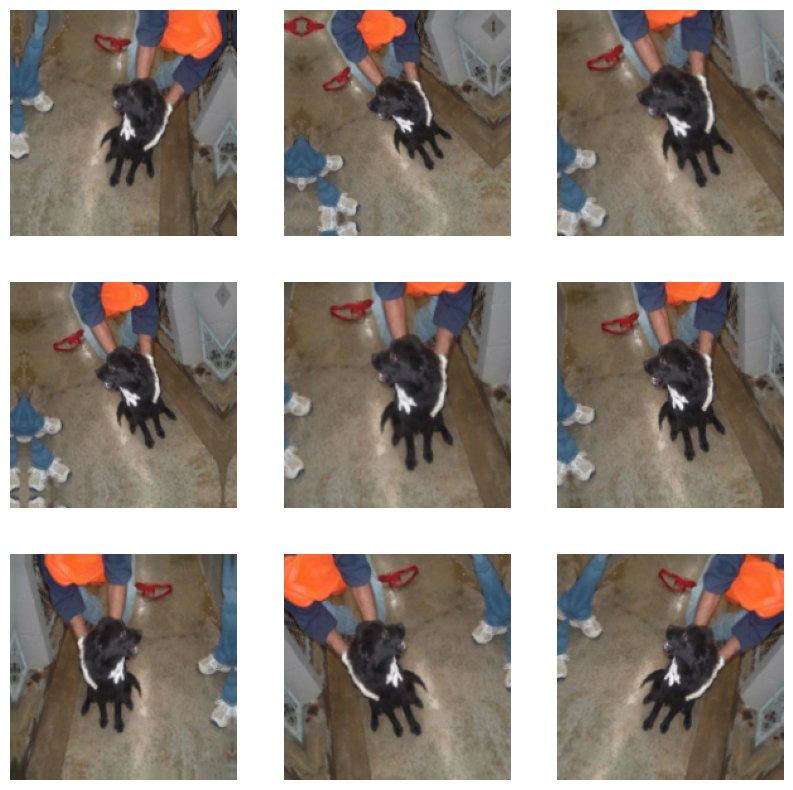

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_pics = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_pics[0].numpy().astype("uint8"))
        plt.axis("off")

Developing a new convolutional neural network that includes picture augmentation and dropout


In [26]:
input2 = keras.Input(shape=(180, 180, 3))
m = augmentation(input2)
m = layers.Rescaling(1./255)(m)
m = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.MaxPooling2D(pool_size=2)(m)
m = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(m)
m = layers.Flatten()(m)
m = layers.Dropout(0.5)(m)
output2 = layers.Dense(1, activation="sigmoid")(m)
model2 = keras.Model(inputs=input2, outputs=output2)

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback2 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model2.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callback2)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.4910 - loss: 0.7026 - val_accuracy: 0.5840 - val_loss: 0.6859
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5872 - loss: 0.6876 - val_accuracy: 0.5860 - val_loss: 0.6727
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5848 - loss: 0.6783 - val_accuracy: 0.5700 - val_loss: 0.6988
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5855 - loss: 0.6694 - val_accuracy: 0.5890 - val_loss: 0.6667
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6083 - loss: 0.6659 - val_accuracy: 0.6210 - val_loss: 0.6334
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6216 - loss: 0.6427 - val_accuracy: 0.5840 - val_loss: 0.7851
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6165 - loss: 0.6676 - val_accuracy: 0.6360 - val_loss: 0.6398
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6641 - loss: 0.6296 - val_accuracy: 0.5910 - 

Model evaluated based on test set

In [28]:
testacc2 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = testacc2.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7836 - loss: 0.4762
Test accuracy: 0.804


Question 3:

In the third step, training sets of 2000 samples were employed, with 500 samples reserved for validation and testing. I discovered that the test accuracy was superior with 1500 training samples compared to 1000 or 2000. Moreover, training accuracy improved with 1000 training samples. Increasing the training set to 2000 while maintaining the same validation and testing sets resulted in these findings.

In [29]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

Click enter to edit the data

In [30]:
i3 = keras.Input(shape=(180, 180, 3))
n = augmentation(i3)
n = layers.Rescaling(1./255)(n)
n = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.MaxPooling2D(pool_size=2)(n)
n = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(n)
n = layers.Flatten()(n)
n = layers.Dropout(0.5)(n)
out3 = layers.Dense(1, activation="sigmoid")(n)
mod3 = keras.Model(inputs=i3, outputs=out3)

mod3.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [31]:
callback3 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
hist3 = mod3.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=callback3)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5085 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5145 - loss: 0.6932 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5405 - loss: 0.6901 - val_accuracy: 0.5070 - val_loss: 0.7259
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5626 - loss: 0.6749 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5113 - loss: 0.6930 - val_accuracy: 0.5010 - val_loss: 0.6937
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5023 - loss: 0.6929 - val_accuracy: 0.5510 - val_loss: 0.6914
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.5449 - loss: 0.6914 - val_accuracy: 0.5150 - val_loss: 0.6917
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.5318 - loss: 0.6908 - val_accuracy: 0.5780 - v

In [32]:
acc_test3 = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = acc_test3.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8035 - loss: 0.4668
Test accuracy: 0.805


Question 4:


Creating the VGG16 convolutional base

In [33]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
convolution_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Utilizing a pre-trained model for feature extraction without data augmentation: Obtaining the labels associated with the VGG16 characteristics

In [35]:
import numpy as np

def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)

train_features, train_labels =  get_features_and_labels(train)
val_features, val_labels =  get_features_and_labels(validation)
test_features, test_labels =  get_features_and_labels(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [36]:
train_features.shape

(2000, 5, 5, 512)

In [37]:
i6 = keras.Input(shape=(5, 5, 512))
p = layers.Flatten()(i6)
p = layers.Dense(256)(p)
p = layers.Dropout(0.5)(p)
out6 = layers.Dense(1, activation="sigmoid")(p)
m6 = keras.Model(i6, out6)
m6.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callback6 = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
hist6 = m6.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callback6)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8700 - loss: 22.0649 - val_accuracy: 0.9510 - val_loss: 8.3680
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9761 - loss: 3.0818 - val_accuracy: 0.9760 - val_loss: 3.0220
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - loss: 1.9675 - val_accuracy: 0.9650 - val_loss: 5.0891
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9855 - loss: 1.1799 - val_accuracy: 0.9740 - val_loss: 3.6258
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9903 - loss: 1.4614 - val_accuracy: 0.9760 - val_loss: 4.6777
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9953 - loss: 0.4865 - val_accuracy: 0.9790 - val_loss: 3.8926
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.1459 - val_accuracy: 0.9640 - val_loss: 9.6983
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9961 - loss: 0.1508 - val_accuracy: 0.9780 - val_los

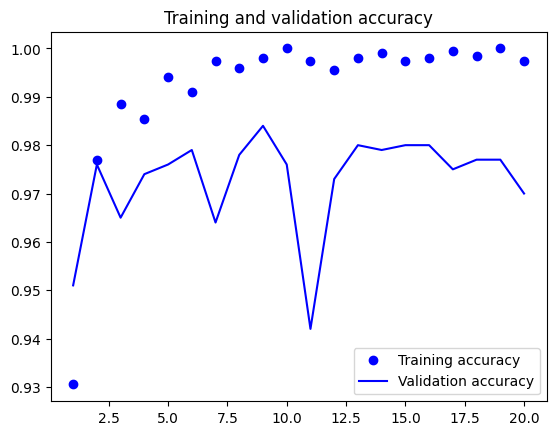

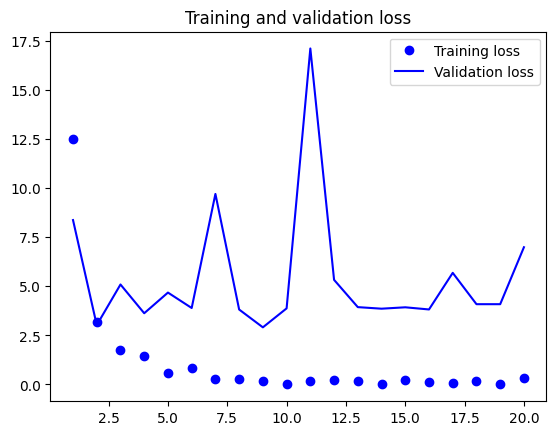

In [38]:
import matplotlib.pyplot as plt
accuracy6 = hist6.history["accuracy"]
valaccuracy6 = hist6.history["val_accuracy"]
los6 = hist6.history["loss"]
vallos6 = hist6.history["val_loss"]
epochs = range(1, len(accuracy6) + 1)
plt.plot(epochs, accuracy6, "bo", label="Training accuracy")
plt.plot(epochs, valaccuracy6, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, los6, "bo", label="Training loss")
plt.plot(epochs, vallos6, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


VGG16 convolutional base instantiation and freezing

In [39]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

convolution_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

convolution_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Model is now performing with a classifier and agumentation to convulation base

In [40]:
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
     lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.8239 - loss: 51.9657 - val_accuracy: 0.9670 - val_loss: 3.6817
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.9517 - loss: 5.4933 - val_accuracy: 0.9740 - val_loss: 2.9366
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.9477 - loss: 6.5372 - val_accuracy: 0.9330 - val_loss: 14.2858
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9493 - loss: 5.2048 - val_accuracy: 0.9750 - val_loss: 3.7424
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9598 - loss: 4.7611 - val_accuracy: 0.9760 - val_loss: 4.9396
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9612 - loss: 5.7594 - val_accuracy: 0.9750 - val_loss: 3.6142
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9706 - loss: 2.5897 - val_accuracy: 0.9790 - val_loss: 2.3751
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9781 - loss: 2.2594 - val_ac

In [42]:
!ls -lh features_extraction_with_augmentation2.keras


-rw-r--r-- 1 root root 82M Oct 21 03:11 features_extraction_with_augmentation2.keras


In [43]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16

# Define the model
augmentation2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

input22 = keras.Input(shape=(180, 180, 3))

a1 = augmentation2(input22)

# Specify output_shape for Lambda layer
a1 = keras.layers.Lambda(
    lambda x: vgg16.preprocess_input(x),
    output_shape=(180, 180, 3)
)(a1)

a1 = convolution_base(a1)
a1 = layers.Flatten()(a1)
a1 = layers.Dense(256)(a1)
a1 = layers.Dropout(0.5)(a1)
outputs = layers.Dense(1, activation="sigmoid")(a1)

model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Save the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="features_extraction_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.8234 - loss: 37.3641 - val_accuracy: 0.8580 - val_loss: 31.6120
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.9230 - loss: 9.7153 - val_accuracy: 0.9540 - val_loss: 7.9000
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.9567 - loss: 5.6781 - val_accuracy: 0.9600 - val_loss: 6.5357
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9611 - loss: 5.5948 - val_accuracy: 0.9790 - val_loss: 3.2763
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9664 - loss: 3.7052 - val_accuracy: 0.9760 - val_loss: 4.2968
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.9685 - loss: 2.8560 - val_accuracy: 0.9820 - val_loss: 2.6743
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9705 - loss: 3.5364 - val_accuracy: 0.9790 - val_loss: 2.5737
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.9714 - loss: 2.5616 - val_ac

Fine-tuning a pretrained model

Freezing all layers until the fourth from the last

In [44]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbackstu = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
historytune = model.fit(
    train,
    epochs=30,
    validation_data=validation,
    callbacks=callbackstu)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.9774 - loss: 2.6888 - val_accuracy: 0.9810 - val_loss: 1.9645
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.9825 - loss: 0.8490 - val_accuracy: 0.9810 - val_loss: 1.9390
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.9822 - loss: 0.9897 - val_accuracy: 0.9850 - val_loss: 1.8810
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9893 - loss: 0.7837 - val_accuracy: 0.9810 - val_loss: 2.3771
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9859 - loss: 0.7598 - val_accuracy: 0.9790 - val_loss: 1.9564
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.9833 - loss: 0.7961 - val_accuracy: 0.9830 - val_loss: 1.6876
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9929 - loss: 0.2419 - val_accuracy: 0.9800 - val_loss: 2.5692
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.9874 - loss: 0.5872 - val_accu

In [46]:
model_tuning = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9666 - loss: 2.3639
Test accuracy: 0.966


In [47]:
ls


cats_vs_dogs_small/                            features_extraction_with_augmentation2.keras
cats_vs_dogs_small_Q2/                         fine_tuning.keras
cats_vs_dogs_small_Q3/                         kaggle.json
convnet_from_scratch.keras                     sample_data/
convnet_from_scratch_with_augmentation1.keras  sampleSubmission.csv
convnet_from_scratch_with_augmentation.keras   test1.zip
dogs-vs-cats.zip                               train/
feature_extraction.keras                       train.zip


In [51]:
!jupyter nbconvert --to html Sai_Prasad(1).ipynb

[NbConvertApp] WARNING | pattern 'Sai_Prasad.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    